# Dropout and Regularization: Preventing Overfitting in Neural Networks (PyTorch Tutorial)

**Module**: Machine Learning Tutorial (Individual Assignment)  
Student: PADMASRI VEERAMACHANENI

**Framework**: PyTorch

---

## What this tutorial covers

In this tutorial, I explore how **dropout regularization** affects:

- **Overfitting prevention** - How dropout helps models generalize better
- **Training stability** - Loss and accuracy curves across epochs  
- **Decision boundaries** - How regularization affects learned patterns

I use a binary classification task on the **Breast Cancer Wisconsin dataset**, reduced to two principal components using PCA, so that we can visualize decision boundaries in 2D while still working with a real-world dataset.

I compare the following dropout rates in PyTorch:

- **No Dropout** (0.0) - Baseline prone to overfitting
- **Light Dropout** (0.2) - Mild regularization  
- **Standard Dropout** (0.5) - Common practice
- **Heavy Dropout** (0.7) - Aggressive regularization

The architecture (layers, optimizer, learning rate) is kept **fixed**.  
The only change between experiments is the **dropout rate** in the hidden layers.


In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn for data
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [ ]:
# Load the dataset
data = load_breast_cancer()
X = data.data  # shape: (n_samples, 30)
y = data.target  # 0=benign, 1=malignant

feature_names = data.feature_names
target_names = data.target_names

print("Original feature shape:", X.shape)
print("Class labels:", target_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

print("PCA-transformed train shape:", X_train_2d.shape)
print("PCA-transformed test shape:", X_test_2d.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance retained:", pca.explained_variance_ratio_.sum())


Original feature shape: (569, 30)
Class labels: ['malignant' 'benign']
Train shape: (455, 30)
Test shape: (114, 30)
PCA-transformed train shape: (455, 2)
PCA-transformed test shape: (114, 2)
Explained variance ratio: [0.44413492 0.18944618]
Total variance retained: 0.6335811006772492


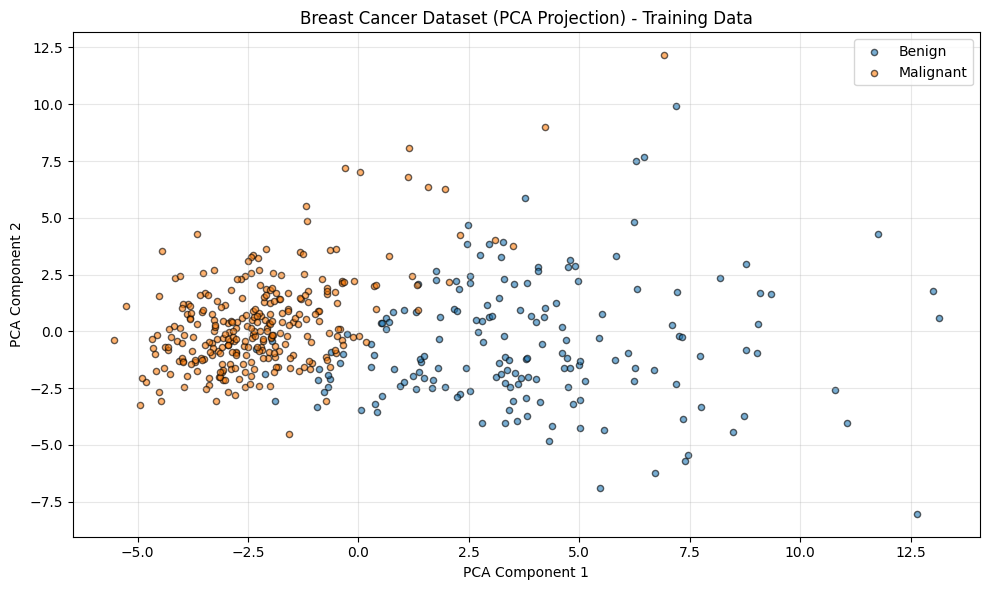

In [ ]:
plt.figure(figsize=(10, 6))

# Plot training data
for label, color, name in [(0, 'tab:blue', 'Benign'), (1, 'tab:orange', 'Malignant')]:
    mask = (y_train == label)
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1],
                c=color, edgecolor='k', s=20, label=name, alpha=0.6)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Breast Cancer Dataset (PCA Projection) - Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_2d, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_2d, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training batches:", len(train_loader))
print("Test batches:", len(test_loader))


Training batches: 15
Test batches: 4


In [ ]:
class BinaryClassifier(nn.Module):
    """
    Neural network with configurable dropout rate.
    Architecture: 2 → 64 → Dropout → 64 → Dropout → 1
    """
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.dropout_rate = dropout_rate

        self.network = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Test instantiation
model = BinaryClassifier(dropout_rate=0.5)
print(model)


BinaryClassifier(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001):
    """
    Train a binary classifier and track metrics.
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.size(0)

        # Validation phase
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                test_loss += loss.item() * X_batch.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                test_correct += (preds == y_batch).sum().item()
                test_total += y_batch.size(0)

        # Record epoch metrics
        history['train_loss'].append(train_loss / train_total)
        history['train_acc'].append(train_correct / train_total)
        history['test_loss'].append(test_loss / test_total)
        history['test_acc'].append(test_correct / test_total)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, "
                  f"Train Acc: {history['train_acc'][-1]:.4f} | "
                  f"Test Loss: {history['test_loss'][-1]:.4f}, "
                  f"Test Acc: {history['test_acc'][-1]:.4f}")

    return history


In [ ]:
# Define dropout rates to compare
dropout_rates = {
    'No Dropout': 0.0,
    'Light (0.2)': 0.2,
    'Standard (0.5)': 0.5,
    'Heavy (0.7)': 0.7
}

# Train all models
results = {}

for name, dropout_rate in dropout_rates.items():
    print(f"\n{'='*60}")
    print(f"Training: {name} (dropout={dropout_rate})")
    print('='*60)

    # Create and train model
    model = BinaryClassifier(dropout_rate=dropout_rate).to(device)
    history = train_model(model, train_loader, test_loader, epochs=100, lr=0.001)

    results[name] = {
        'model': model,
        'history': history,
        'dropout_rate': dropout_rate
    }

    print(f"✓ Final Test Accuracy: {history['test_acc'][-1]:.4f}")



Training: No Dropout (dropout=0.0)
Epoch 20/100 | Train Loss: 0.1161, Train Acc: 0.9604 | Test Loss: 0.1367, Test Acc: 0.9386
Epoch 40/100 | Train Loss: 0.1138, Train Acc: 0.9626 | Test Loss: 0.1460, Test Acc: 0.9474
Epoch 60/100 | Train Loss: 0.1121, Train Acc: 0.9538 | Test Loss: 0.1463, Test Acc: 0.9474
Epoch 80/100 | Train Loss: 0.1132, Train Acc: 0.9648 | Test Loss: 0.1540, Test Acc: 0.9386
Epoch 100/100 | Train Loss: 0.1137, Train Acc: 0.9560 | Test Loss: 0.1488, Test Acc: 0.9298
✓ Final Test Accuracy: 0.9298

Training: Light (0.2) (dropout=0.2)
Epoch 20/100 | Train Loss: 0.1152, Train Acc: 0.9516 | Test Loss: 0.1440, Test Acc: 0.9474
Epoch 40/100 | Train Loss: 0.1308, Train Acc: 0.9473 | Test Loss: 0.1421, Test Acc: 0.9474
Epoch 60/100 | Train Loss: 0.1261, Train Acc: 0.9604 | Test Loss: 0.1449, Test Acc: 0.9474
Epoch 80/100 | Train Loss: 0.1129, Train Acc: 0.9538 | Test Loss: 0.1467, Test Acc: 0.9474
Epoch 100/100 | Train Loss: 0.1071, Train Acc: 0.9626 | Test Loss: 0.1480, Te

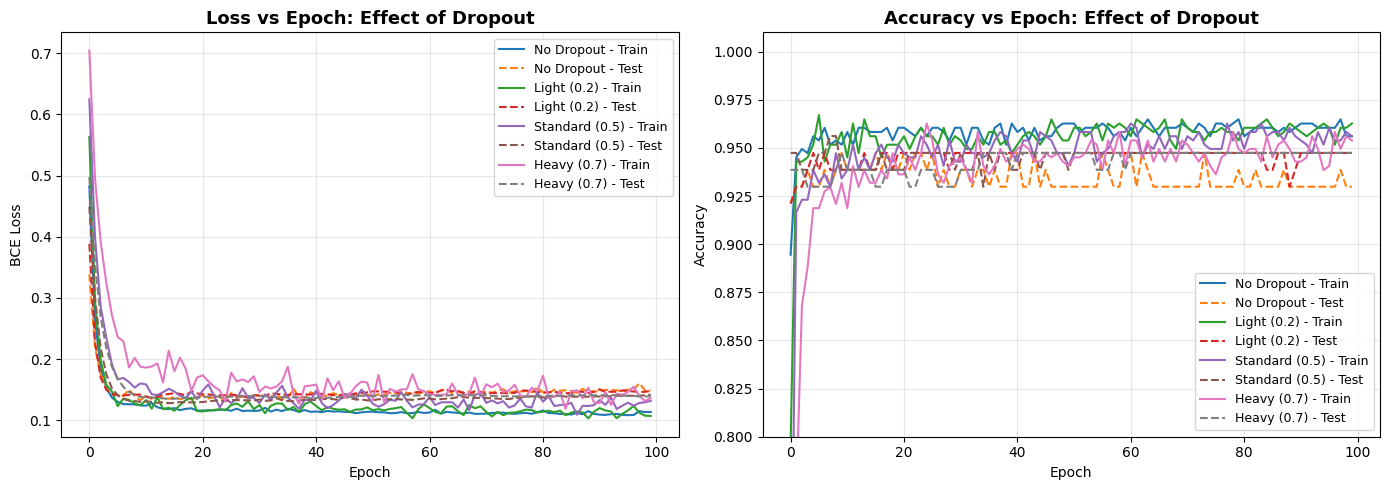

In [ ]:
plt.figure(figsize=(14, 5))

# Training loss
plt.subplot(1, 2, 1)
for name in dropout_rates.keys():
    history = results[name]['history']
    plt.plot(history['train_loss'], label=f'{name} - Train', linestyle='-')
    plt.plot(history['test_loss'], label=f'{name} - Test', linestyle='--')

plt.title('Loss vs Epoch: Effect of Dropout', fontsize=13, weight='bold')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Training accuracy
plt.subplot(1, 2, 2)
for name in dropout_rates.keys():
    history = results[name]['history']
    plt.plot(history['train_acc'], label=f'{name} - Train', linestyle='-')
    plt.plot(history['test_acc'], label=f'{name} - Test', linestyle='--')

plt.title('Accuracy vs Epoch: Effect of Dropout', fontsize=13, weight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Create summary DataFrame
summary_rows = []

for name in dropout_rates.keys():
    history = results[name]['history']
    summary_rows.append({
        'Dropout Rate': name,
        'Final Train Loss': history['train_loss'][-1],
        'Final Test Loss': history['test_loss'][-1],
        'Final Train Acc': history['train_acc'][-1],
        'Final Test Acc': history['test_acc'][-1],
        'Overfitting Gap': history['train_acc'][-1] - history['test_acc'][-1]
    })

summary_df = pd.DataFrame(summary_rows)
summary_df


,Dropout Rate,Final Train Loss,Final Test Loss,Final Train Acc,Final Test Acc,Overfitting Gap
0,No Dropout,0.113676,0.148841,0.956044,0.929825,0.026219
1,Light (0.2),0.107139,0.148041,0.962637,0.947368,0.015269
2,Standard (0.5),0.131637,0.141790,0.956044,0.947368,0.008676
3,Heavy (0.7),0.136101,0.139178,0.953846,0.947368,0.006478



Decision boundary for: NO DROPOUT


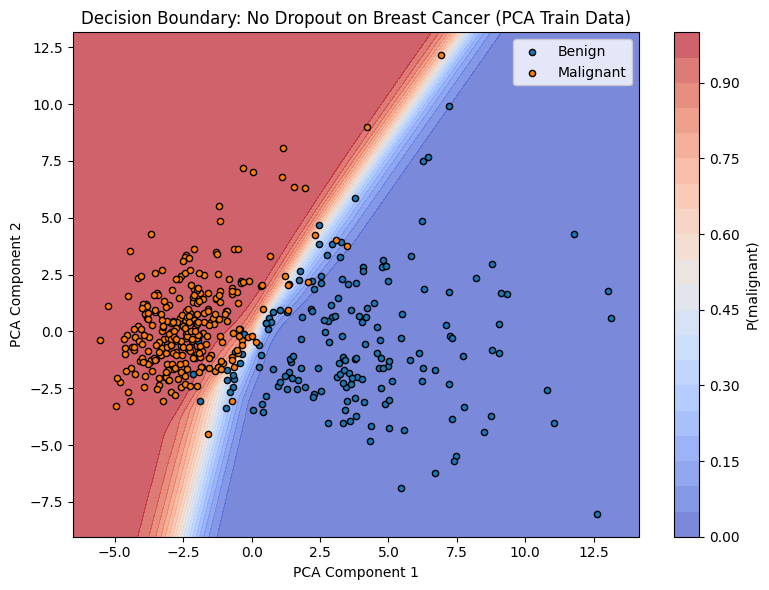


Decision boundary for: LIGHT (0.2)


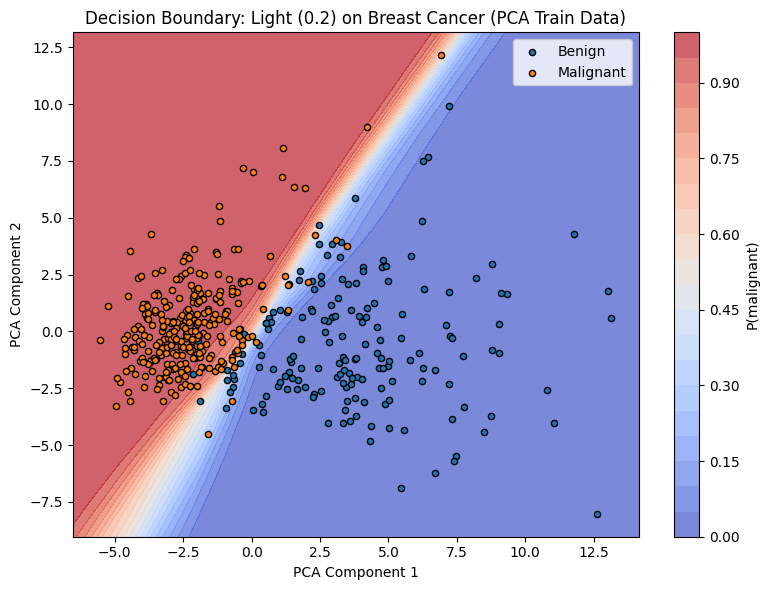


Decision boundary for: STANDARD (0.5)


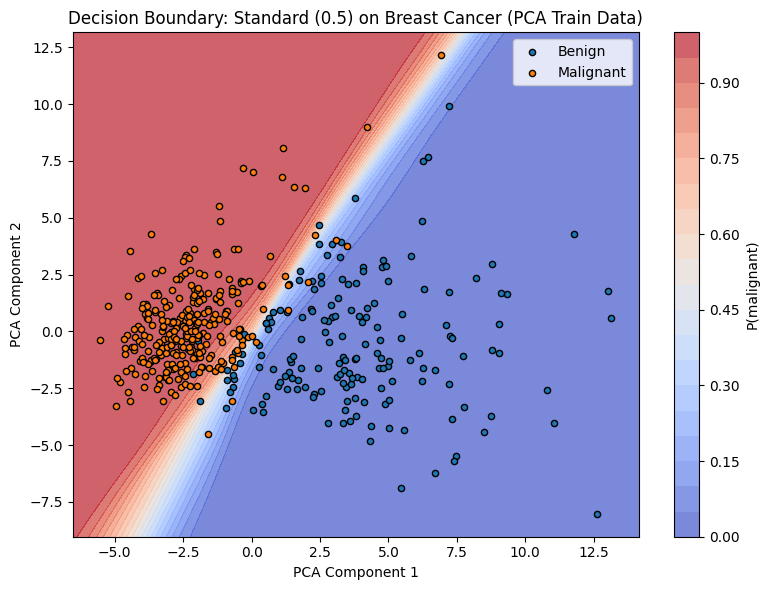


Decision boundary for: HEAVY (0.7)


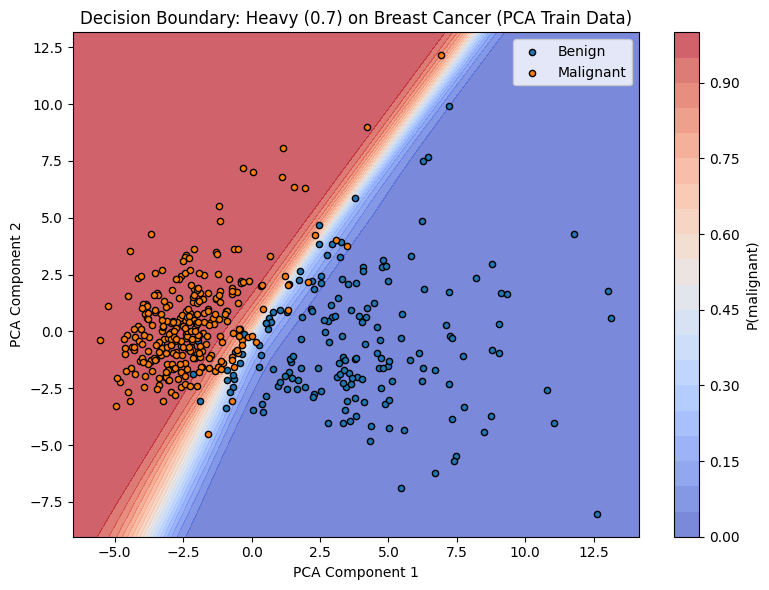

In [ ]:
def plot_decision_boundary(model, X, y, title=""):
    """Plot decision boundary for a trained binary classifier on 2D input."""
    model.eval()
    model.to(device)

    # Create mesh
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(grid_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(8, 6))

    # Contour of prediction probabilities
    contour = plt.contourf(xx, yy, probs, levels=20, alpha=0.7, cmap='coolwarm')
    plt.colorbar(contour, label='P(malignant)')

    # Overlay training points
    for label, color, name in [(0, 'tab:blue', 'Benign'), (1, 'tab:orange', 'Malignant')]:
        mask = (y == label)
        plt.scatter(X[mask, 0], X[mask, 1],
                   c=color, edgecolor='k', s=20, label=name)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot decision boundaries for all models
X_train_np = X_train_2d
y_train_np = y_train

for name in dropout_rates.keys():
    print(f"\nDecision boundary for: {name.upper()}")
    model = results[name]['model']
    plot_decision_boundary(
        model,
        X_train_np,
        y_train_np,
        title=f"Decision Boundary: {name} on Breast Cancer (PCA Train Data)"
    )
